In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import random

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import multiprocessing

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
def causal_genes_in_neighbourhood(G, causal_genes, node):
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    causal_genes_in_neighbourhood = [x for x in sub_G.nodes() if x in causal_genes]
    if causal_genes_in_neighbourhood:
        return causal_genes_in_neighbourhood
    else:
        return []

In [3]:
def causal_genes_at_distance(dict_distances, node, d):
    try:
        return len([dist for dist in dict_distances.get(node).values() if dist == d])
    except:
        return 0

In [4]:
PHENOTYPE = "MMAF"

In [5]:
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)
causal_genes = pd.read_pickle(f"./data/candidateGenesList_{PHENOTYPE}.p")

G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)

causal_genes = list(set([c for c in causal_genes if c in G.nodes()]))
nonCausal_genes = [n for n in G.nodes() if n not in causal_genes] 


print(f"Interactome size: {len(G.nodes())}, number of MMAF candidates in interactome: {len(causal_genes)}")

Interactome size: 14465, number of MMAF candidates in interactome: 40


In [199]:
# interactome = np.genfromtxt("./data/Interactome_human.tsv", delimiter='\t', dtype=str)

# G = nx.Graph()

# for row in interactome:
#     node1, node2, interaction = row
#     G.add_edge(node1, node2)

# causal_genes = np.load(f"./data/candidateGenesList_{PHENOTYPE}.p", allow_pickle=True)

# causal_genes = list(set([c for c in causal_genes if c in G.nodes()]))
# nonCausal_genes = [n for n in G.nodes() if n not in causal_genes] 

# print(f"Interactome size: {G.number_of_nodes()} nodes, {G.number_of_edges()}, number of {PHENOTYPE} candidates in interactome: {len(causal_genes)}")

In [6]:
# find distances between MMAF and non-MMAF genes
dict_distances = {}
longest_distance = 0

for source_node in tqdm(nonCausal_genes):
    dict_tmp = {}

    for target_node in causal_genes:
        try:
            distance = nx.shortest_path_length(G, source_node, target_node)
            dict_tmp[target_node] = distance

            if distance > longest_distance:
                longest_distance = distance
        except:
            continue

    dict_distances[source_node] = dict_tmp

print(f"Longest distance between {PHENOTYPE} and non-{PHENOTYPE} gene: {longest_distance}")

  0%|          | 0/14425 [00:00<?, ?it/s]

100%|██████████| 14425/14425 [00:25<00:00, 565.94it/s]

Longest distance between MMAF and non-MMAF gene: 10


### Calculate new centrality for every non-causal gene

In [286]:
# # calculate adjacency matrices to the powers up to longest distance between causal and non-causal genes

# # create a dictionary to store matrices with structure
# # {power : A^power,
# # ...}

# dict_adjacency_bool = {}

# # get A to the power of 1
# A = nx.adjacency_matrix(G)
# A_sparse = sp.sparse.csr_matrix(A, dtype=bool)
# A_sparse.setdiag(0) 
# dict_adjacency_bool[1] = A_sparse

# # get A to the power of 2
# res = A_sparse.dot(A_sparse)
# res_sparse = sp.sparse.csr_matrix(res, dtype=bool)
# res_sparse.setdiag(0)
# dict_adjacency_bool[2] = res_sparse

# # get A to the powers of up to 4
# for power in tqdm(range(3, 5)):
#     res = res.dot(A_sparse)
#     res_sparse = sp.sparse.csr_matrix(res, dtype=bool)
#     res_sparse.setdiag(0)
#     dict_adjacency_bool[power] = res_sparse

In [287]:
# calculate adjacency matrices to the powers up to longest distance between causal and non-causal genes

# create a dictionary to store matrices with structure
# {power : A^power,
# ...}

dict_adjacency = {}

# get A to the power of 1
A = nx.adjacency_matrix(G)
A_sparse = sp.sparse.csr_matrix(A, dtype=bool)
A_sparse.setdiag(0)
dict_adjacency[1] = A_sparse

# get A to the power of 2
res = A_sparse.dot(A_sparse)
res.setdiag(0)
# res_distance = res == 2
res_sparse = sp.sparse.csr_matrix(res, dtype=bool)
dict_adjacency[2] = res_sparse

# get A to the powers of up to 4
for power in tqdm(range(3, 5)):
    res = res.dot(A_sparse)
    res_sparse.setdiag(0)
    # res_distance = res == power
    res_sparse = sp.sparse.csr_matrix(res, dtype=bool)
    dict_adjacency[power] = res_sparse

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 2/2 [00:10<00:00,  5.15s/it]


In [285]:
# set alpha parameter
alpha = 0.5

In [304]:
# a 1D array with size=len(G.nodes()): 0 if non-causal and 1/(alpha*N_causal) for causal
causal_genes_array = np.array([1 if n in causal_genes else 0 for n in G.nodes()]).reshape(-1, 1)

scores = np.zeros((len(causal_genes_array))).reshape(-1, 1)
norm_factors = np.zeros(len(causal_genes_array)).reshape(-1, 1)


for d in range(1, 5):
    A = dict_adjacency.get(d)
    scores += 0.5 ** d * A.dot(causal_genes_array)

    norm_factors += 0.3 ** d * np.sum(A, axis=1)

scores_normalized = np.squeeze(scores / norm_factors)

dict_scores = dict(zip(G.nodes(), scores_normalized))

dict_scores_sorted = dict(sorted(dict_scores.items(), key=lambda v: v[1], reverse=True))

dict_scores_sorted = {k: v for k, v in dict_scores_sorted.items() if k not in causal_genes}

/tmp/ipykernel_9007/821364049.py:14: RuntimeWarning: invalid value encountered in divide
  scores_normalized = np.squeeze(scores / norm_factors)


In [305]:
# get more info about each node (degree, causal genes at distances)
for n, score in dict_scores_sorted.items():
    dict_scores_sorted[n] = [score, 
                             G.degree(n), 
                             causal_genes_at_distance(dict_distances, n, 1), 
                             causal_genes_at_distance(dict_distances, n, 2),
                             causal_genes_at_distance(dict_distances, n, 3),
                             causal_genes_at_distance(dict_distances, n, 4)]

df = pd.DataFrame.from_dict(dict_scores_sorted, 
                            orient='index', 
                            columns=['score', 'degree', 'causal genes at d=1', 'causal genes at d=2', 'causal genes at d=3', 'causal genes at d=4'])

In [306]:
# get gene names to ENSG
genes_df = pd.read_csv("./data/canonicalGenes.tsv", sep='\t')

df_res = genes_df.merge(df, right_index=True, left_on='ENSG')
df_res.sort_values(by='score', inplace=True, ascending=False)
df_res.reset_index(inplace=True, drop=True)

In [320]:
# get top 20 genes
df_top = df_res.tail(20)
df_top

,GENE,ENSG,score,degree,causal genes at d=1,causal genes at d=2,causal genes at d=3,causal genes at d=4
14405,NLRP7,ENSG00000167634,NaN,2,0,0,0,0
14406,TRPV3,ENSG00000167723,NaN,2,0,0,0,0
14407,SFTPB,ENSG00000168878,NaN,2,0,0,0,0
14408,PDGFD,ENSG00000170962,NaN,2,0,0,0,0
14409,CES2,ENSG00000172831,NaN,2,0,0,0,0
14410,HPSE2,ENSG00000172987,NaN,2,0,0,0,0
14411,PC,ENSG00000173599,NaN,2,0,0,0,0
14412,CHRNA9,ENSG00000174343,NaN,2,0,0,0,0
14413,INHBC,ENSG00000175189,NaN,2,0,0,0,0
14414,ST8SIA3,ENSG00000177511,NaN,2,0,0,0,0


In [321]:
connected_component = nx.node_connected_component(G, 'ENSG00000167634')
subgraph = G.subgraph(connected_component)
subcomponents_nodes = list(subgraph.nodes())
len(subcomponents_nodes) / len(G)

6.91323885240235e-05

### Analyze the results

Text(0.5, 1.0, 'New centrality scores histogram')

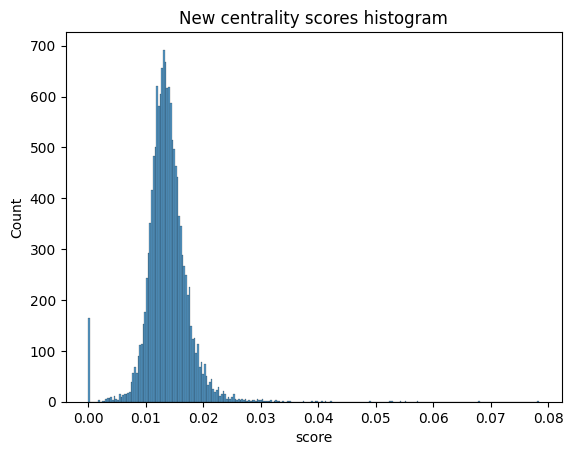

In [308]:
sns.histplot(data=df, x='score')
plt.title("New centrality scores histogram")

Text(0.5, 1.0, 'New centrality scores')

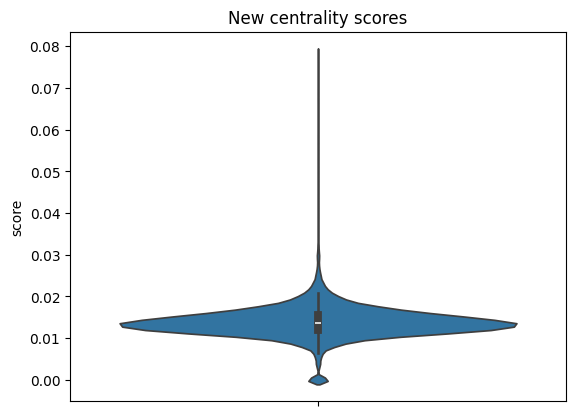

In [309]:
sns.violinplot(data=df, y='score')
plt.title("New centrality scores")

Text(0.5, 1.0, 'New centrality scores vs. node degree')

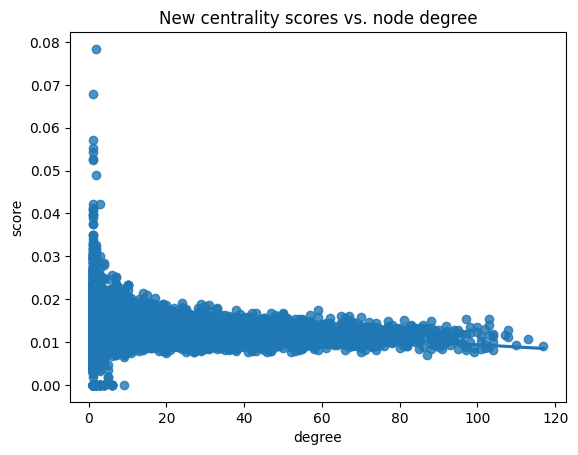

In [310]:
sns.regplot(data=df, x="degree", y="score")
plt.title("New centrality scores vs. node degree")

### Analyze scores for new candidates from 13/02/2024

In [128]:
new_candidates = ['CLHC1', 'PHF20', 'NUSAP1', 'CDC20B', 'FAM221A', 'GALR3', 'LRRC9', 'KIF27', 'ZNF208', 'C6orf118', 'CCDC66', 'CCNA1', 'DDX43', 'FSCB', 'FHAD1', 'LRGUK', 'MYCBPAP', 'MYH7B', 'PCDHB15', 'SAMD15', 'SPACA9', 'SPATA24', 'SPATA6', 'TSSK4', 'TTLL2']
dict_new_candidates = dict([(gene, genes_df[genes_df['GENE'] == gene]['ENSG'].values[0]) for gene in new_candidates])

In [129]:
# check what percentage of new candidates is in interactome
len([nc for nc in dict_new_candidates.values() if nc in G.nodes()]) / len(dict_new_candidates.values())

0.68

In [130]:
# check scores of new candidates
df_new_candidates = df_res[df_res['ENSG'].isin(dict_new_candidates.values())]
df_new_candidates

,GENE,ENSG,score,degree,causal genes at d=1,causal genes at d=2,causal genes at d=3,causal genes at d=4
1576,CDC20B,ENSG00000164287,9.978958e+07,11,0,3,7,23
2638,CCNA1,ENSG00000133101,4.334574e+07,17,0,3,10,24
5353,SPATA6,ENSG00000132122,8.737950e+06,3,0,0,10,21
5437,FAM221A,ENSG00000188732,8.359322e+06,6,0,2,7,22
7620,MYH7B,ENSG00000078814,2.513813e+06,5,0,0,6,17
7892,CCDC66,ENSG00000180376,2.125540e+06,1,1,1,4,11
7900,SPATA24,ENSG00000170469,2.115177e+06,7,0,1,3,27
8167,KIF27,ENSG00000165115,1.817077e+06,3,0,1,4,21
8823,SPACA9,ENSG00000165698,1.252110e+06,3,0,0,6,26
10908,MYCBPAP,ENSG00000136449,3.056646e+05,3,0,1,4,13


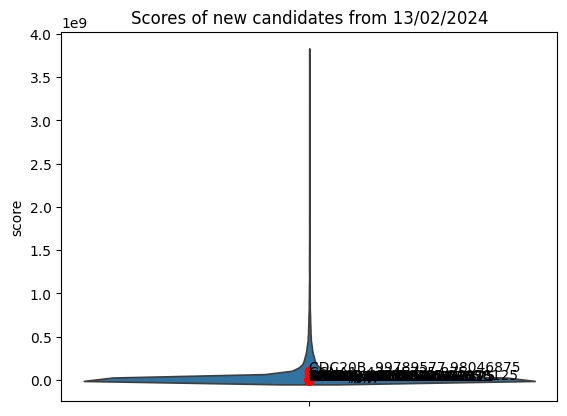

In [131]:
# plot scores of new candidates
sns.violinplot(data=df, y='score')
plt.title("Scores of new candidates from 13/02/2024")

for idx, row in df_new_candidates.iterrows():
    gene = row['GENE']
    score = row['score']
    plt.plot(score, 'or')
    plt.text(0, score, s=f"{gene}, {score}")

### Leave-one-out experiment: one gene

In [138]:
# remove a candidate from candidates list
left_out = causal_genes[1]

left_out_idx = causal_genes.index(left_out)

causal_genes_new = causal_genes[:left_out_idx] + causal_genes[left_out_idx+1:]

print(f"Removed gene {left_out} from causal genes list")

# add the removed candidate to non-candidates list
nonCausal_genes_new = [n for n in G.nodes() if n not in causal_genes_new] 

Removed gene ENSG00000157796 from causal genes list


In [139]:
# # calculate new centrality for every non-MMAF gene
# dict_scores = {}

# nodes_list = list(G.nodes())

# for node in tqdm(nonCandidates_MMAF_new):NOA
#     node_idx = nodes_list.index(node)

#     score = 0
    
#     for candidate in candidates_MMAF_new:
#         candidate_idx = nodes_list.index(candidate)

#         try:
#             # if there's no path connecting node to candidate then there's no contribution to node score
#             d = nx.shortest_path_length(G, node, candidate)
            
#             if d > 4:
#                 continue
            
#             else:
#                 A = dict_adjacency.get(d)
#                 score += alpha ** d * A[node_idx, candidate_idx]
        
#         except:
#             continue

#     dict_scores[node] = score
    
# dict_scores_sorted = dict(sorted(dict_scores.items(), key=lambda v: v[1], reverse=True))

In [140]:
# calculate new centrality for every non-MMAF gene
causal_genes_array = np.array([1/(alpha * len(causal_genes_new)) if n in causal_genes_new else 0 for n in G.nodes()]).reshape(-1, 1)

scores = np.zeros((len(causal_genes_array))).reshape(-1, 1)
norm_factors = np.zeros((len(causal_genes_array))).reshape(-1, 1)

for d in range(1, 5):
    A = dict_adjacency.get(d)
    scores += alpha ** d * A.dot(causal_genes_array)

    norm_factors += (1 / (alpha * len(G.nodes())) * alpha ** d) * np.sum(A, axis=1)

scores_normalized = np.squeeze(scores / norm_factors)

dict_scores = dict(zip(G.nodes(), scores_normalized))

dict_scores_sorted = dict(sorted(dict_scores.items(), key=lambda v: v[1], reverse=True))

dict_scores_sorted = {k: v for k, v in dict_scores_sorted.items() if k not in causal_genes_new}

In [141]:
# recalculate distances between causal and non-causal genes
dict_distances_new = {}
longest_distance = 0

for source_node in tqdm(nonCausal_genes_new):
    dict_tmp = {}

    for target_node in causal_genes_new:
        try:
            distance = nx.shortest_path_length(G, source_node, target_node)
            dict_tmp[target_node] = distance

            if distance > longest_distance:
                longest_distance = distance
        except:
            continue

    dict_distances_new[source_node] = dict_tmp

print(f"Longest distance between {PHENOTYPE} and non-{PHENOTYPE} gene: {longest_distance}")

  0%|          | 0/14426 [00:00<?, ?it/s]

100%|██████████| 14426/14426 [00:37<00:00, 384.73it/s]

Longest distance between MMAF and non-MMAF gene: 10


In [142]:
# get more info about each node (degree, causal genes at distances)
dict_scores_full = {}

for n, score in dict_scores_sorted.items():
    dict_scores_full[n] = [score, 
                             G.degree(n), 
                             causal_genes_at_distance(dict_distances_new, n, 1), 
                             causal_genes_at_distance(dict_distances_new, n, 2),
                             causal_genes_at_distance(dict_distances_new, n, 3),
                             causal_genes_at_distance(dict_distances_new, n, 4)]

df_new = pd.DataFrame.from_dict(dict_scores_full, 
                            orient='index', 
                            columns=['score', 'degree', 'causal genes at d=1', 'causal genes at d=2', 'causal genes at d=3', 'causal genes at d=4'])

In [143]:
# get gene names to ENSG
genes_df = pd.read_csv("./data/canonicalGenes.tsv", sep='\t')

df_res_new = df_new.merge(genes_df, left_index=True, right_on='ENSG')
df_res_new.sort_values(by='score', inplace=True, ascending=False)
df_res_new.reset_index(inplace=True, drop=True)

In [144]:
# find results for the left-out gene
df_res_new[df_res_new['ENSG'] == left_out]

,score,degree,causal genes at d=1,causal genes at d=2,causal genes at d=3,causal genes at d=4,GENE,ENSG
3167,0.963842,10,0,0,11,20,WDR19,ENSG00000157796


In [145]:
# get top 20 genes
df_top_new = df_res_new.head(20)
df_top_new

,score,degree,causal genes at d=1,causal genes at d=2,causal genes at d=3,causal genes at d=4,GENE,ENSG
0,4.659516,2,1,0,0,5,LRRC40,ENSG00000066557
1,3.733867,1,0,0,0,3,SLC30A5,ENSG00000145740
2,3.065268,1,0,0,0,4,NBPF1,ENSG00000219481
3,3.003218,1,0,0,0,2,RASGEF1C,ENSG00000146090
4,2.929680,1,0,0,1,3,HAPLN1,ENSG00000145681
5,2.882623,1,0,0,0,3,ZNF519,ENSG00000175322
6,2.880757,1,0,0,0,8,SRFBP1,ENSG00000151304
7,2.824092,2,0,0,0,3,ZNF273,ENSG00000198039
8,2.546207,1,0,0,1,3,SNX21,ENSG00000124104
9,2.519684,1,0,0,1,2,ZSCAN2,ENSG00000176371


/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0, 0.9638423193216038, 'ENSG00000157796, 0.9638423193216038')

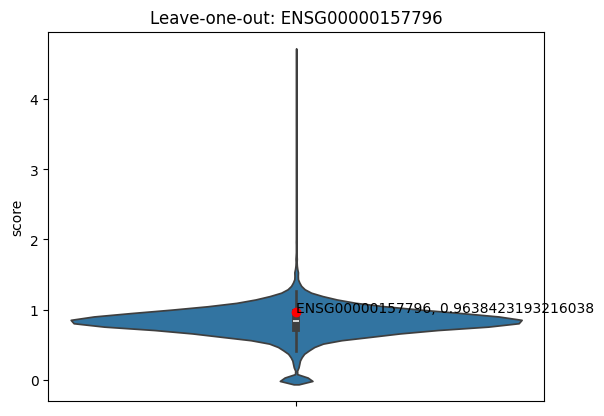

In [146]:
# plot score of the left-out gene
sns.violinplot(data=df_new, y='score')
plt.title(f"Leave-one-out: {left_out}")

score = df_res_new[df_res_new['ENSG'] == left_out]['score'].values[0]
plt.plot(score, 'or')
plt.text(0, score, s=f"{left_out}, {score}")

### Leave-one-out experiment: all causal genes

In [16]:
def calculate_newCentrality(causal_gene):
    # remove one candidate from candidate list
    causal_gene_idx = causal_genes.index(causal_gene)
    left_out = causal_genes[causal_gene_idx]

    causal_genes_new = causal_genes[:causal_gene_idx] + causal_genes[causal_gene_idx+1:]

    print(f"Removed gene {left_out} from causal genes list\n")

    # # add the removed candidate to non-candidates list
    # nonCandidates_MMAF_new = [n for n in G.nodes() if n not in candidates_MMAF_new]

    # # calculate new centrality for every non-MMAF gene
    # dict_scores = {}

    # nodes_list = list(G.nodes())

    # for node in tqdm(nonCandidates_MMAF_new):
    #     node_idx = nodes_list.index(node)

    #     score = 0
        
    #     for candidate in candidates_MMAF_new:
    #         candidate_idx = nodes_list.index(candidate)

    #         try:
    #             # if there's no path connecting node to candidate then there's no contribution to node score
    #             d = nx.shortest_path_length(G, node, candidate)
                
    #             if d > 4:
    #                 continue
                
    #             else:
    #                 A = dict_adjacency.get(d)
    #                 score += alpha ** d * A[node_idx, candidate_idx]
            
    #         except:
    #             continue

    #     dict_scores[node] = score
        
    # dict_scores_sorted = dict(sorted(dict_scores.items(), key=lambda v: v[1], reverse=True)) 

    # calculate new centrality for every non-MMAF gene
    causal_genes_array = np.array([1/(alpha * len(causal_genes_new)) if n in causal_genes_new else 0 for n in G.nodes()]).reshape(-1, 1)

    scores = np.zeros((len(causal_genes_array))).reshape(-1, 1)
    norm_factors = np.zeros((len(causal_genes_array))).reshape(-1, 1)

    for d in range(1, 5):
        A = dict_adjacency.get(d)
        scores += alpha ** d * A.dot(causal_genes_array)

        norm_factors += (1 / (alpha * len(G.nodes())) * alpha ** d) * np.sum(A, axis=1)

    scores_normalized = np.squeeze(scores / norm_factors)

    dict_scores = dict(zip(G.nodes(), scores_normalized))

    dict_scores_sorted = dict(sorted(dict_scores.items(), key=lambda v: v[1], reverse=True))

    dict_scores_sorted = {k: v for k, v in dict_scores_sorted.items() if k not in causal_genes_new}

    df_new = pd.DataFrame.from_dict(dict_scores_sorted, 
                                orient='index', 
                                columns=['score'])
    
    return df_new, left_out

Removed gene ENSG00000159625 from causal genes list
Removed gene ENSG00000111254 from causal genes list
Removed gene ENSG00000124721 from causal genes list
Removed gene ENSG00000105792 from causal genes list
Removed gene ENSG00000120051 from causal genes list
Removed gene ENSG00000174799 from causal genes list
Removed gene ENSG00000119661 from causal genes list

Removed gene ENSG00000141013 from causal genes list







Removed gene ENSG00000140623 from causal genes list

Removed gene ENSG00000139537 from causal genes list

Removed gene ENSG00000147081 from causal genes list

Removed gene ENSG00000187775 from causal genes list

Removed gene ENSG00000129646 from causal genes list

Removed gene ENSG00000066185 from causal genes list

Removed gene ENSG00000188738 from causal genes list

Removed gene ENSG00000179532 from causal genes list

Removed gene ENSG00000167646 from causal genes list

Removed gene ENSG00000165164 from causal genes list

Removed gene ENSG00000174844 from causal genes

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

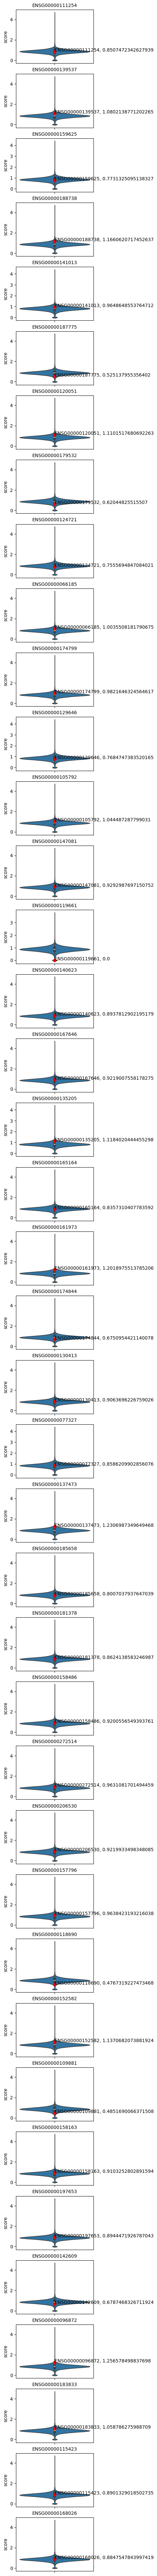

CPU times: user 16.1 s, sys: 13.5 s, total: 29.6 s
Wall time: 37.7 s


In [17]:
%%time

fig, ax = plt.subplots(len(causal_genes), 1, figsize=(3, 100))

# create a dictionary to save scores for left-out causal genes
dict_causal_genes = {}

# for plotting
i = 0

pool_obj = multiprocessing.Pool()

res_dataframes = pool_obj.map(calculate_newCentrality, causal_genes)

pool_obj.close()

for results in res_dataframes:
    df_new = results[0]
    left_out = results[1]
    # plot score of the left-out gene
    sns.violinplot(data=df_new, y='score', ax=ax[i])

    score = df_new.loc[left_out]['score']
    ax[i].plot(score, 'or')
    ax[i].text(0, score, s=f"{left_out}, {score}")
    ax[i].legend().remove()
    ax[i].set_title(left_out, fontsize=10)

    dict_causal_genes[left_out] = score

    # for keeping track of plotting
    i += 1

plt.show()

### Compare non-causal genes scores (all causal genes used) with scores for causal genes (leave-one-out)

In [18]:
# create dataframe with scores for non-causal genes scores (all causal genes used)
df_nonCausal = df[['score']]
df_nonCausal['group'] = f"non{PHENOTYPE}"

# create dataframe with scores for causal genes (leave-one-out)
df_leaveOneOut = pd.DataFrame.from_dict(dict_causal_genes, orient='index', columns=['score'])
df_leaveOneOut['group'] = "leaveOneOut"

# concatenate dataframes for comparison
df_compare = pd.concat([df_nonCausal, df_leaveOneOut])

/tmp/ipykernel_26593/298997869.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonCausal['group'] = f"non{PHENOTYPE}"


(0.0, 4.0)

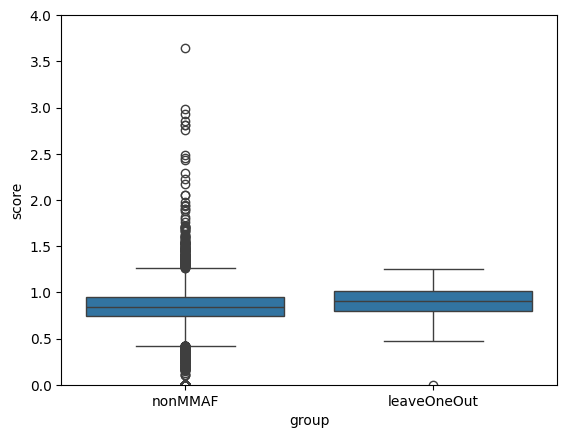

In [19]:
# plot scores of new candidates
sns.boxplot(data=df_compare, x='group', y='score')
plt.ylim(0, 4)

In [20]:
# Wilcoxon rank-sum statistical test with outliers

from scipy.stats import ranksums

stat, p_value = ranksums(df_nonCausal['score'].values, df_leaveOneOut['score'].values, alternative='less')
stat, p_value

(-2.12586560206363, 0.016757225875576886)

#### Remove outliers

In [ ]:
# Method 1: Remove outliers based on quantiles

Q1 = df_nonCausal['score'].quantile(0.25)
Q3 = df_nonCausal['score'].quantile(0.75)
IQR = Q3 - Q1

df_nonCausal_no_outliers = df_nonCausal[(df_nonCausal['score'] > Q1 - 1.5 * IQR) & (df_nonCausal['score'] < Q3 + 1.5 * IQR)]

Q1 = df_leaveOneOut['score'].quantile(0.25)
Q3 = df_leaveOneOut['score'].quantile(0.75)
IQR = Q3 - Q1

df_leaveOneOut_no_outliers = df_leaveOneOut[(df_leaveOneOut['score'] > Q1 - 1.5 * IQR) & (df_leaveOneOut['score'] < Q3 + 1.5 * IQR)]

In [ ]:
# # Method 2: Remove outliers based on Z-score

# from scipy.stats import zscore

# # Assuming df is your DataFrame and 'column_name' is the column where you want to remove outliers
# z_scores = zscore(df_nonMMAF['score'])
# threshold = 3

# # Remove rows with outliers
# df_nonMMAF_no_outliers = df_nonMMAF[(z_scores < threshold) & (z_scores > -threshold)]

# # repeat for the other df
# z_scores = zscore(df_leaveOneOut['score'])
# df_leaveOneOut_no_outliers = df_leaveOneOut[(z_scores < threshold) & (z_scores > -threshold)]

#### Check if data with outliers removed is normaly distributed

In [ ]:
from scipy.stats import shapiro 

s, p = shapiro(df_nonCausal_no_outliers['score'].values)
if p > 0.05:
    print("It's normally distributed")
else:
    print("It's not normally distributed")

It's not normally distributed


/tmp/ipykernel_8346/1446431068.py:3: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 13759.
  s, p = shapiro(df_nonCausal_no_outliers['score'].values)


In [ ]:
s, p = shapiro(df_leaveOneOut_no_outliers['score'].values)
if p > 0.05:
    print("It's normally distributed")
else:
    print("It's not normally distributed")

It's normally distributed


In [ ]:
# concatenate dataframes for comparison
df_compare_no_outliers = pd.concat([df_nonCausal_no_outliers, df_leaveOneOut_no_outliers])

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


(0.0, 4.0)

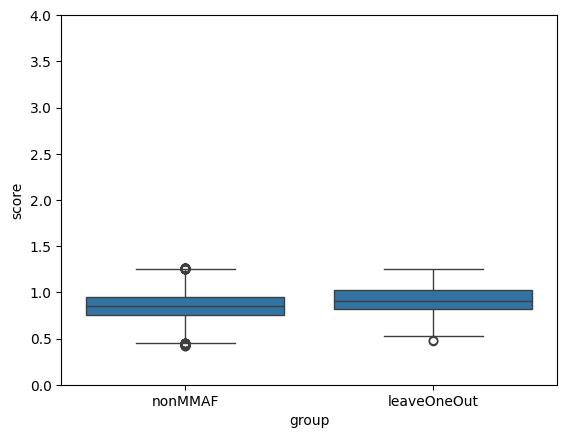

In [ ]:
# plot scores of new candidates
sns.boxplot(data=df_compare_no_outliers, x='group', y='score')
plt.ylim(0, 4)

### Check tatistically significant difference

In [ ]:
# Wilcoxon rank-sum statistical test without outliers

from scipy.stats import ranksums

stat, p_value = ranksums(df_nonCausal_no_outliers['score'].values, df_leaveOneOut_no_outliers['score'].values, alternative='less')
stat, p_value

(-2.349577887100355, 0.00939735575190431)

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


Text(0.5, 1.0, 'Compare non-causal genes scores (all MMAF genes used)\n with scores for MMAF genes (leave-one-out)')

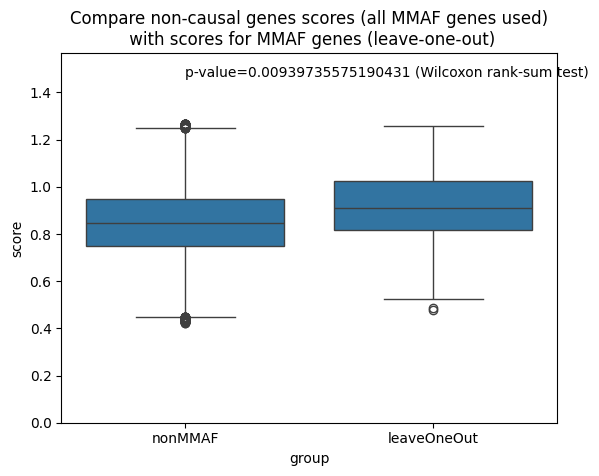

In [ ]:
# plot scores of new candidates
sns.boxplot(data=df_compare_no_outliers, x='group', y='score')
plt.ylim(0, df_compare_no_outliers['score'].max() + 0.3)
plt.text(0, df_compare_no_outliers['score'].max() + 0.2, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
plt.title(f"Compare non-causal genes scores (all {PHENOTYPE} genes used)\n with scores for {PHENOTYPE} genes (leave-one-out)")